ID Number: 33385806

# EEG-based BCI using Visual Imagery and Emotiv Epoc X:  An Exploratory Study

## MSc Thesis for Computational Cognitive Neuroscience 2020/2021

### Decoding analysis using time-frequency features with SVM, LR, LDA, RF
### In this notebook, features are extracted from the occipital channels

### Import Libraries

In [1]:
%%capture libraries   

import sys
import os
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install mne
!{sys.executable} -m pip install mne-features
import numpy as np
import matplotlib 
import pathlib
import mne
import seaborn as sns
import pandas as pd
from mne.io import concatenate_raws, read_raw_edf
from mne import Epochs, create_info, events_from_annotations
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs,corrmap
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch, tfr_stockwell,tfr_multitaper,tfr_array_morlet,AverageTFR
from scipy import signal
from scipy.integrate import simps
matplotlib.use('Qt5Agg') #allow interactive plots
import matplotlib.pyplot as plt
from mne.decoding import GeneralizingEstimator, Scaler,cross_val_multiscore, LinearModel, get_coef, Vectorizer, CSP, SlidingEstimator
from mne.viz import centers_to_edges
from mne.baseline import rescale
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, ShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support, precision_recall_curve, average_precision_score, plot_precision_recall_curve, ConfusionMatrixDisplay, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_roc_curve, accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
%run EEG_functions_1.ipynb import load_data, excl_chan, filter_data, make_epochs, plot_data, epochs_power

### Load the cleaned epoched dataset

Include only the occipital channels O1 and O2

In [2]:
epochs_occ= mne.read_epochs('epoched_data_280-epo.fif', preload=True) 
epochs_occ.drop_channels(['AF3','F7','F3','FC5','T7','P7','P8','T8','FC6','F4','F8','AF4']) 


Reading epoched_data_280-epo.fif ...
    Found the data of interest:
        t =     250.00 ...    9746.09 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated


<EpochsFIF |  280 events (all good), 0.25 - 9.74609 sec, baseline [0, 0] sec (baseline period was cropped after baseline correction), ~10.4 MB, data loaded,
 'Push': 142
 'Relax': 138>

In [3]:
print(epochs_occ.get_data().shape) #check the shape, it should be (280,2,2432) n_epochs, n_channels, n_timepoints

(280, 2, 2432)


#### Equalize the number of epochs count in each condition 



In [4]:
mne.Epochs.equalize_event_counts(epochs_occ, event_ids=epochs_occ.event_id)
print(type(epochs_occ)) #double-check it's EpochsFIF
print(epochs_occ.get_data().shape)  #check the shape, n_epochs, n_channels, n_timepoints

Dropped 4 epochs: 132, 167, 204, 271
<class 'mne.epochs.EpochsFIF'>
(276, 2, 2432)


### Firstly, compute Time-Frequency Analysis (TFR) using Morlet Wavelet Transfom:

In [5]:
freqs = np.logspace(*np.log10([2, 30]), num=40) # define frequencies of interest (log-spaced) 
n_cycles = freqs / 2.  # different number of cycle per frequency

power_occ = mne.time_frequency.tfr_morlet(epochs_occ, freqs=freqs, n_cycles=n_cycles, use_fft=True, average=False,
                                           return_itc=False, decim=3, n_jobs=1) #only occipital signal


print(power_occ.data.shape) 

Not setting metadata
(276, 2, 40, 811)


In [6]:
#Extract TFR features in Theta band (4-7Hz)

n_col= power_occ.data.shape[3] #extract n columns from power_occ
n_chan=power_occ.data.shape[1] #extract n channels
n_row= power_occ.data.shape[0] #extract n rows


theta_pow_occ = np.zeros(shape=(n_row,n_chan,n_col))  
counter=0
for samples in range (0,n_row):
    for chan in range(0, n_chan):
        pow_t = power_occ.data[samples][chan][(power_occ.freqs>=4) & (power_occ.freqs<7)][:]  
        counter+=1
        pow_avg_t = np.mean(pow_t, axis=0) 
        theta_pow_occ[samples,chan,:]=pow_avg_t

In [37]:
#Extract TFR features in Alpha band (8-12Hz)

n_col= power_occ.data.shape[3] #extract n columns from pw output
n_chan=power_occ.data.shape[1] #extract n channels
n_row= power_occ.data.shape[0] #extract n rows

alpha_pow_occ = np.zeros(shape=(n_row,n_chan,n_col))   
counter=0
for samples in range (0,n_row):
    for chan in range(0, n_chan): 
        pow_a = power_occ.data[samples][chan][(power_occ.freqs>=8) & (power_occ.freqs<12)][:]  
        counter+=1
        pow_avg_a = np.mean(pow_a, axis=0)  
        alpha_pow_occ[samples,chan,:]=pow_avg_a

In [66]:
#Extract TFR features in Beta band (13-30Hz)

n_col= power_occ.data.shape[3] #extract n columns from pw output
n_chan=power_occ.data.shape[1] #extract n channels
n_row= power_occ.data.shape[0] #extract n rows

beta_pow_occ = np.zeros(shape=(n_row,n_chan,n_col))    
counter=0
for samples in range (0,n_row):
    for chan in range(0, n_chan): 
        pow_b = power_occ.data[samples][chan][(power_occ.freqs>=13) & (power_occ.freqs<30)][:]  
        counter+=1
        pow_avg_b = np.mean(pow_b, axis=0)  
        beta_pow_occ[samples,chan,:]=pow_avg_b


### Prepare the dataset to fed into the classifiers:



Firstly, initialise the below variables to store the accuracies from all classifiers:

In [7]:
accuracies, f1_scores = [], [] #run this cell only once

Define the input data:

In [68]:
data= beta_pow_occ  #Define the features: theta_pow_occ, alpha_pow_occ, beta_pow_occ
labels = epochs_occ.events[:,-1] #our labels

In [69]:
#Double-check the shape 

print(np.shape(data))
print(np.shape(labels))

(276, 2, 811)
(276,)


 Split the dataset into training and testing with a 70:30 ratio (Training:Test):


In [70]:
#specifiy a random state to replicate the result
train_data, test_data, labels_train, labels_test = train_test_split(data, labels, test_size=0.30, random_state=37) 



### Define the Support Vector Machine(SVM)

In [71]:
clf_svm_pip = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(probability=True))  #define pipeline
parameters = {'svc__kernel':['linear', 'rbf', 'sigmoid'], 'svc__C':[0.1, 1, 10], 'svc__gamma':[0.1,0.01,0.001]}
#Apply GridSearchCV to identify the best parameters
gs_cv_svm = GridSearchCV(clf_svm_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=10), return_train_score=True) 

#Training is done by passing the training data and their labels to fit() function.

gs_cv_svm.fit(train_data, labels_train)
print('Best Parameters: {}'.format(gs_cv_svm.best_params_))
print('Best Score: {}'.format(gs_cv_svm.best_score_))


predictions_svm = gs_cv_svm.predict(test_data)

#Evaluate
report_svm = classification_report(labels_test, predictions_svm, target_names=['Relax', 'Push'])
print('SVM Clasification Report:\n {}'.format(report_svm))

acc_svm = accuracy_score(labels_test, predictions_svm)
print("Accuracy of SVM model: {}".format(acc_svm))

precision_svm,recall_svm,fscore_svm,support_svm=precision_recall_fscore_support(labels_test,predictions_svm,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_svm,recall_svm,fscore_svm))

Best Parameters: {'svc__C': 1, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Best Score: 0.6423684210526315
SVM Clasification Report:
               precision    recall  f1-score   support

       Relax       0.56      0.66      0.60        38
        Push       0.66      0.56      0.60        45

    accuracy                           0.60        83
   macro avg       0.61      0.61      0.60        83
weighted avg       0.61      0.60      0.60        83

Accuracy of SVM model: 0.6024096385542169
Precision: 0.6067251461988304, Recall: 0.6067251461988304, f1-score:0.6024096385542169


In [72]:
#Area Under Curve (AUC) value
auc = roc_auc_score(labels_test, predictions_svm)
print('ROC AUC: %f' % auc)

ROC AUC: 0.606725


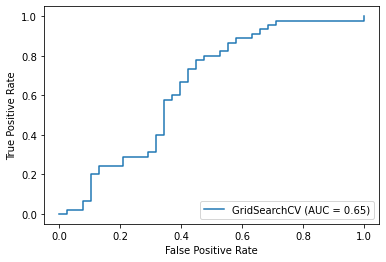

In [73]:
#ROC result
svm_roc = plot_roc_curve(gs_cv_svm, test_data, labels_test)  

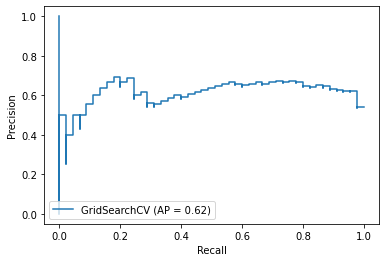

In [74]:
#Precision-Recall result
svm_pr = plot_precision_recall_curve(gs_cv_svm, test_data, labels_test) #precision-recall curve

In [75]:
# Performance metrics
errors_svc = abs(predictions_svm - labels_test)
print('Average absolute error:', round(np.mean(errors_svc), 2), 'degrees.')

Average absolute error: 0.4 degrees.


### Linear Discriminant Analysis (LDA)

In [76]:
clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis())
parameters = {'lineardiscriminantanalysis__solver':['svd']}
gs_cv_lda = GridSearchCV(clf_lda_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=10), return_train_score=True) 
gs_cv_lda.fit(train_data,labels_train)
 
print('Best Parameters: {}'.format(gs_cv_lda.best_params_))
print('Best Score: {}'.format(gs_cv_lda.best_score_))


#Predictions
predictions_lda = gs_cv_lda.predict(test_data)

#Evaluation
report_lda = classification_report(labels_test, predictions_lda, target_names=['Relax', 'Push'])
print('LDA Clasification Report:\n {}'.format(report_lda))

acc_lda = accuracy_score(labels_test, predictions_lda)
print("Accuracy of LDA model: {}".format(acc_lda))

precision_lda,recall_lda,fscore_lda,support_lda=precision_recall_fscore_support(labels_test,predictions_lda,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lda,recall_lda,fscore_lda))

Best Parameters: {'lineardiscriminantanalysis__solver': 'svd'}
Best Score: 0.5221052631578947
LDA Clasification Report:
               precision    recall  f1-score   support

       Relax       0.56      0.53      0.54        38
        Push       0.62      0.64      0.63        45

    accuracy                           0.59        83
   macro avg       0.59      0.59      0.59        83
weighted avg       0.59      0.59      0.59        83

Accuracy of LDA model: 0.5903614457831325
Precision: 0.5862884160756501, Recall: 0.5853801169590643, f1-score:0.5854876615746181


In [77]:
#Area Under Curve (AUC) value
auc = roc_auc_score(labels_test, predictions_lda)
print('ROC AUC: %f' % auc)

ROC AUC: 0.585380


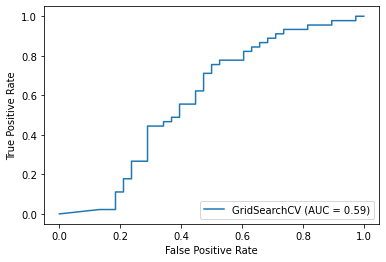

In [78]:
#ROC 
lda_roc = plot_roc_curve(gs_cv_lda, test_data, labels_test) 

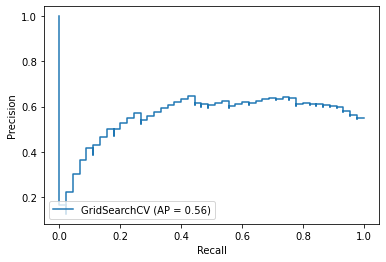

In [79]:
#Precision-Recall 
lda_pr = plot_precision_recall_curve(gs_cv_lda,test_data, labels_test)  

In [80]:
# Performance metrics
errors_lda = abs(predictions_lda - labels_test)
print('Average absolute error:', round(np.mean(errors_lda), 2), 'degrees.')

Average absolute error: 0.41 degrees.


### Logistic Regression (LR)

In [81]:
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(max_iter=5000))
parameters ={'logisticregression__C': np.logspace(0, 4, 100)}  


gs_cv_lr = GridSearchCV(clf_lr_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=10))
gs_cv_lr.fit(train_data, labels_train)

print('Best Parameters: {}'.format(gs_cv_lr.best_params_))
print('Best Score: {}'.format(gs_cv_lr.best_score_))

#Predictions
predictions_lr = gs_cv_lr.predict(test_data)

#Evaluation
report_lr = classification_report(labels_test, predictions_lr, target_names=['Relax', 'Push'])
print('LR Clasification Report:\n {}'.format(report_lr))

acc_lr = accuracy_score(labels_test, predictions_lr)
print("Accuracy of LR model: {}".format(acc_lr))

precision_lr,recall_lr,fscore_lr,support_lr=precision_recall_fscore_support(labels_test,predictions_lr,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lr,recall_lr,fscore_lr))

Best Parameters: {'logisticregression__C': 1.0}
Best Score: 0.5213157894736842
LR Clasification Report:
               precision    recall  f1-score   support

       Relax       0.47      0.50      0.49        38
        Push       0.56      0.53      0.55        45

    accuracy                           0.52        83
   macro avg       0.52      0.52      0.52        83
weighted avg       0.52      0.52      0.52        83

Accuracy of LR model: 0.5180722891566265
Precision: 0.5165697674418605, Recall: 0.5166666666666666, f1-score:0.5163170163170163


In [82]:
#Area Under Curve (AUC) value
auc = roc_auc_score(labels_test, predictions_lr)
print('ROC AUC: %f' % auc)

ROC AUC: 0.516667


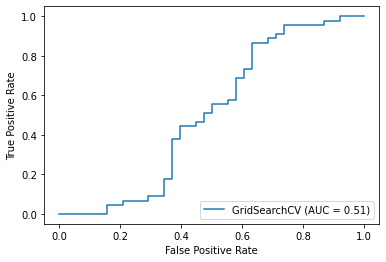

In [83]:
#ROC
lr_roc = plot_roc_curve(gs_cv_lr, test_data, labels_test)  

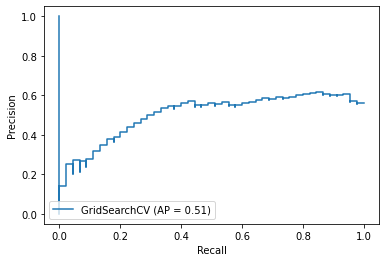

In [84]:
#Precision
lr_pr = plot_precision_recall_curve(gs_cv_lr, test_data, labels_test)  

In [85]:
# Performance metrics
errors_lr = abs(predictions_lr - labels_test)
print('Average absolute error:', round(np.mean(errors_lr), 2), 'degrees.')

Average absolute error: 0.48 degrees.


### Random Forest (RF)

In [86]:
clf_rf_pip = make_pipeline(Vectorizer(), StandardScaler(), RandomForestClassifier()) 
parameters = {'randomforestclassifier__n_estimators':[100,200,300,400,500,600,700], 'randomforestclassifier__criterion':['gini', 'entropy'], 'randomforestclassifier__max_depth':[1,2,3,4,5]} 
gs_cv_rf = GridSearchCV(clf_rf_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=10), return_train_score=True)  
gs_cv_rf.fit(train_data,labels_train)

print('Best Parameters: {}'.format(gs_cv_rf.best_params_))
print('Best Score: {}'.format(gs_cv_rf.best_score_))

predictions_rf = gs_cv_rf.predict(test_data)

#Evaluation
report_rf = classification_report(labels_test, predictions_rf, target_names=['Relax', 'Push'])
print('RF Clasification Report:\n {}'.format(report_rf))

acc_rf = accuracy_score(labels_test, predictions_rf)
print("Accuracy of RF model: {}".format(acc_rf))

precision_rf,recall_rf,fscore_rf,support_rf=precision_recall_fscore_support(labels_test,predictions_rf,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_rf,recall_rf,fscore_rf))

Best Parameters: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 3, 'randomforestclassifier__n_estimators': 100}
Best Score: 0.6321052631578947
RF Clasification Report:
               precision    recall  f1-score   support

       Relax       0.49      0.58      0.53        38
        Push       0.58      0.49      0.53        45

    accuracy                           0.53        83
   macro avg       0.53      0.53      0.53        83
weighted avg       0.54      0.53      0.53        83

Accuracy of RF model: 0.5301204819277109
Precision: 0.5339181286549708, Recall: 0.5339181286549708, f1-score:0.5301204819277109


In [87]:
#Area Under Curve (AUC) value
auc = roc_auc_score(labels_test, predictions_rf)
print('ROC AUC: %f' % auc)

ROC AUC: 0.533918


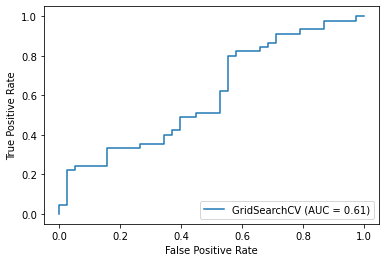

In [88]:
#ROC
rf_roc = plot_roc_curve(gs_cv_rf, test_data, labels_test) 

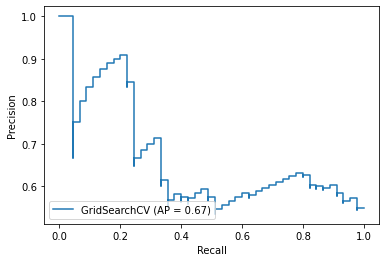

In [89]:
#Precision
rf_pr = plot_precision_recall_curve(gs_cv_rf, test_data, labels_test)  

In [90]:
# Performance metrics
errors_rf = abs(predictions_rf - labels_test)
print('Average absolute error:', round(np.mean(errors_rf), 2), 'degrees.')

Average absolute error: 0.47 degrees.


Store all the classifiers' performance:

In [91]:
accuracies.append([acc_svm, acc_lda, acc_lr, acc_rf])
f1_scores.append([fscore_svm, fscore_lda, fscore_lr, fscore_rf ])

### ROC Curve comparison


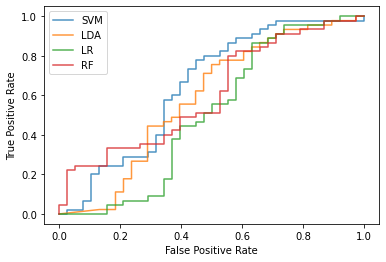

In [92]:
%matplotlib inline

ax = plt.gca()

svm_roc.plot(ax=ax, alpha=0.8,label='SVM')
lda_roc.plot(ax=ax, alpha=0.8,label='LDA')    
lr_roc.plot(ax=ax, alpha=0.8,label='LR')       
rf_roc.plot(ax=ax, alpha=0.8,label='RF')

 
plt.legend()
plt.show()

### Precision-Recall Curve comparison


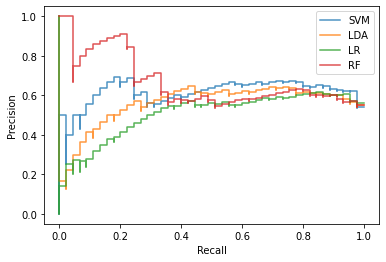

In [93]:
#%matplotlib inline

ax = plt.gca()

svm_pr.plot(ax=ax, alpha=0.8,label='SVM')
lda_pr.plot(ax=ax, alpha=0.8,label='LDA')
lr_pr.plot(ax=ax, alpha=0.8,label='LR')
rf_pr.plot(ax=ax, alpha=0.8,label='RF')

plt.legend()
plt.show()

### Compare the performance of these four different models (Accuracy & F1-score)

In [94]:
print(np.shape(accuracies)) #the final shape should be (3,4)
print(accuracies)

(3, 4)


[[0.5421686746987951,
  0.5060240963855421,
  0.5662650602409639,
  0.5421686746987951],
 [0.6987951807228916,
  0.4939759036144578,
  0.5180722891566265,
  0.5421686746987951],
 [0.6024096385542169,
  0.5903614457831325,
  0.5180722891566265,
  0.5301204819277109]]

In [98]:
print(f1_scores)#check the values

[[0.5367215041128085, 0.5034291551145484, 0.5611045828437133, 0.538888888888889], [0.6871702095582692, 0.4921328671328671, 0.5174418604651163, 0.538888888888889], [0.6024096385542169, 0.5854876615746181, 0.5163170163170163, 0.5301204819277109]]


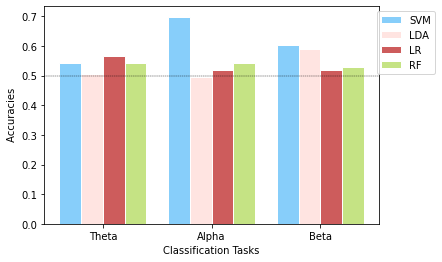

In [96]:
# Plot Accuracy scores

 
barWidth = 0.2 # Choose the width of the bars


bars1 = [row[0] for row in accuracies ]  #SVM
bars2 = [row[1] for row in accuracies ]  #LDA
bars3 = [row[2] for row in accuracies ]  #LR
bars4 = [row[3] for row in accuracies ]  #RF
 


# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]


# Create the bars
ax = plt.axes()
plt.bar(r1, bars1, color='#87CEFA', width=barWidth, edgecolor='white', label='SVM')
plt.bar(r2, bars2, color='#FFE4E1', width=barWidth, edgecolor='white', label='LDA')
plt.bar(r3, bars3, color='#CD5C5C', width=barWidth, edgecolor='white', label='LR')
plt.bar(r4, bars4, color='#C5E384', width=barWidth, edgecolor='white', label='RF')

plt.axhline(y=0.5, color='k', linestyle='--',linewidth=0.4)
plt.xlabel('Classification Tasks')
plt.ylabel(' Accuracies')
ax.set_xticks([0.3,1.3,2.3])
ax.set_xticklabels(['Theta','Alpha','Beta'])
plt.legend(loc="upper left", bbox_to_anchor=(0.98, 1))

plt.show()

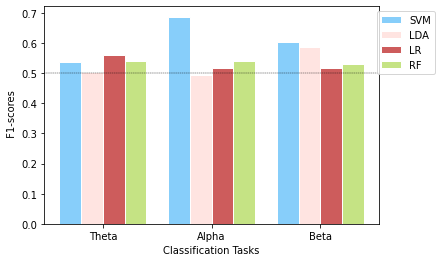

In [97]:
# Plot F1-scores
# Choose the width of the bars
barWidth = 0.2


bars1 = [row[0] for row in f1_scores ] #SVM
bars2 = [row[1] for row in f1_scores ] #LDA
bars3 = [row[2] for row in f1_scores ] #LR 
bars4 = [row[3] for row in f1_scores ] #RF
 

# The x position of bars

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]


# Create the bars
ax = plt.axes()
plt.bar(r1, bars1, color='#87CEFA', width=barWidth, edgecolor='white', label='SVM')
plt.bar(r2, bars2, color='#FFE4E1', width=barWidth, edgecolor='white', label='LDA')
plt.bar(r3, bars3, color='#CD5C5C', width=barWidth, edgecolor='white', label='LR')
plt.bar(r4, bars4, color='#C5E384', width=barWidth, edgecolor='white', label='RF')

plt.axhline(y=0.5, color='k', linestyle='--',linewidth=0.4)
plt.xlabel('Classification Tasks')
plt.ylabel(' F1-scores')
ax.set_xticks([0.3,1.3,2.3])
ax.set_xticklabels(['Theta','Alpha','Beta'])
plt.legend(loc="upper left", bbox_to_anchor=(0.98, 1))

plt.show()